<a href="https://colab.research.google.com/github/anko191/Python_Kaggle/blob/master/Tensorflow/Overfitting_Underfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting and Underfitting
* Learn from
https://tensorflow.classcat.com/2018/08/27/tensorflow-tutorials-keras-overfit-and-underfit/

## Overfitting

* 住居価格の予測では、検証データ上のモデルの精度がいくつかのエポックの訓練後にピークになり、
* それから減少を開始することを見ました。
    * 換言すれば、モデルは訓練データにoverfitしています。
* overfittingにどのように対処するかを学ぶことは重要です。
    * 訓練セット上で高い精度を獲得することはしばしば可能ですが、
    * 本当に望むことはテストデータ（あるいは前にまだ見ていないデータ）に上手く一般化されたモデルを開発することです。
    

## Underfitting
* 反対は、underfittingで、テストデータ上でまだ改善の余地があるときに発生します。
    * これは多くの理由で起こります
        * モデルが十分にパワフルでない場合
        * 過剰に正規化されている
        * 単に十分に長く訓練されていない場合
        * ネットワークが訓練データ内の関連するパターンを学習していないことを意味しています
* でも**長すぎる訓練**をすると、モデルは**overfit**し始めて、訓練データからテストデータに一般化されないパターンを学習する

## 上手くバランスを取る必要がある
* どのように**適切な数のエポックの間訓練するか**を理解することは下で研究するように有用なスキルです

## overfittingを回避するには
* 最善の解法は**より多くの訓練データを使用すること**です
    * より多くのデータ上で訓練されたモデルは自然により良く一般化されます。
* それが可能じゃないときに、次の解法は、
* **正則化のようなテクニックを使用することです**
    * これらは、モデルが**ストアできる情報の量とタイプに制約を課し**ます
    * ネットワークがパターンの小さい数を記憶するだけの余裕がある場合、
    * **最適化プロセスはそれに最も目立つパターンに注目するように**強制。

## ここで勉強する事
* 重み正則化
* Dropout
* IMDB 映画レビュー分類を使います

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


## IMDB Datasets download

* sentense を multi-hot encoding しましょう
* 迅速にoverfit する。だからどう対処するか。
* multi-hot encodingは、それらを0と1のベクトルに変えることを意味
    * [3,5]を1になるindex3とindex5を除いて、0の10000次元のベクトルに変えることを意味します。

In [2]:
NUM_WORDS = 10000
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words = NUM_WORDS)

In [3]:
print(train_data[:10])

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

In [3]:
def multi_hot_sequences(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0 # 特殊なindex
    return results
train_data = multi_hot_sequences(train_data, dimension = NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension = NUM_WORDS)

In [6]:
print(train_data[:10][0])

[0. 1. 1. ... 0. 0. 0.]


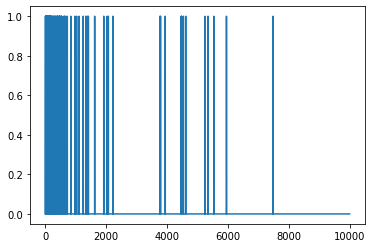

In [7]:
plt.plot(train_data[0])

## 層の大きさについて
* 正しいサイズを決定するための公式はない
* 異なるものを利用して...色々やってみるしかない

### 適切なものを見つけるには
* 比較的少ない層とパラメータで初めて、
* それから検証損失上の戻しが**減衰し始めるまで層のサイズを増やしたり新しい層**を追加

## ベースライン・モデルを作成する

In [7]:
baseline_model = keras.Sequential([
        keras.layers.Dense(16, activation = 'relu', input_shape = (NUM_WORDS, )),
        keras.layers.Dense(16, activation = 'relu'),
        keras.layers.Dense(1, activation = 'sigmoid')
])

baseline_model.compile(optimizer = 'adam',
                       loss = 'binary_crossentropy',
                       metrics = ['accuracy', 'binary_crossentropy'])
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [8]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs = 20,
                                      batch_size = 512,
                                      validation_data = (test_data, test_labels),
                                      verbose = 2)

Epoch 1/20
49/49 - 2s - loss: 0.5146 - accuracy: 0.7838 - binary_crossentropy: 0.5146 - val_loss: 0.3563 - val_accuracy: 0.8721 - val_binary_crossentropy: 0.3563
Epoch 2/20
49/49 - 2s - loss: 0.2639 - accuracy: 0.9060 - binary_crossentropy: 0.2639 - val_loss: 0.2842 - val_accuracy: 0.8873 - val_binary_crossentropy: 0.2842
Epoch 3/20
49/49 - 2s - loss: 0.1905 - accuracy: 0.9330 - binary_crossentropy: 0.1905 - val_loss: 0.2869 - val_accuracy: 0.8865 - val_binary_crossentropy: 0.2869
Epoch 4/20
49/49 - 2s - loss: 0.1520 - accuracy: 0.9478 - binary_crossentropy: 0.1520 - val_loss: 0.3041 - val_accuracy: 0.8828 - val_binary_crossentropy: 0.3041
Epoch 5/20
49/49 - 2s - loss: 0.1254 - accuracy: 0.9593 - binary_crossentropy: 0.1254 - val_loss: 0.3313 - val_accuracy: 0.8766 - val_binary_crossentropy: 0.3313
Epoch 6/20
49/49 - 2s - loss: 0.1047 - accuracy: 0.9666 - binary_crossentropy: 0.1047 - val_loss: 0.3653 - val_accuracy: 0.8717 - val_binary_crossentropy: 0.3653
Epoch 7/20
49/49 - 2s - loss

## より小さいモデルを作成する。
* めっちゃ少なくする

* 隠れ層を小さく

In [14]:
smaller_model = keras.Sequential([
        keras.layers.Dense(4, activation = 'relu', input_shape = (NUM_WORDS, )),
        keras.layers.Dense(4, activation = 'relu'),
        keras.layers.Dense(1, activation = 'sigmoid')
])

smaller_model.compile(optimizer = 'adam',
                       loss = 'binary_crossentropy',
                       metrics = ['accuracy', 'binary_crossentropy'])
smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [15]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.5615 - accuracy: 0.7848 - binary_crossentropy: 0.5615 - val_loss: 0.4472 - val_accuracy: 0.8557 - val_binary_crossentropy: 0.4472
Epoch 2/20
49/49 - 1s - loss: 0.3557 - accuracy: 0.8868 - binary_crossentropy: 0.3557 - val_loss: 0.3390 - val_accuracy: 0.8788 - val_binary_crossentropy: 0.3390
Epoch 3/20
49/49 - 1s - loss: 0.2652 - accuracy: 0.9116 - binary_crossentropy: 0.2652 - val_loss: 0.2978 - val_accuracy: 0.8850 - val_binary_crossentropy: 0.2978
Epoch 4/20
49/49 - 1s - loss: 0.2131 - accuracy: 0.9270 - binary_crossentropy: 0.2131 - val_loss: 0.2850 - val_accuracy: 0.8860 - val_binary_crossentropy: 0.2850
Epoch 5/20
49/49 - 1s - loss: 0.1782 - accuracy: 0.9397 - binary_crossentropy: 0.1782 - val_loss: 0.2836 - val_accuracy: 0.8870 - val_binary_crossentropy: 0.2836
Epoch 6/20
49/49 - 1s - loss: 0.1547 - accuracy: 0.9490 - binary_crossentropy: 0.1547 - val_loss: 0.2937 - val_accuracy: 0.8832 - val_binary_crossentropy: 0.2937
Epoch 7/20
49/49 - 1s - loss

## より大きいモデルを作成しましょう
* 大きすぎると、overfittingしやすいのだ
* それを確認しよう 512ってなんやねｎw

* **しかもめっちゃ長いし**

In [16]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
 
bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])
 
bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [17]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 14s - loss: 0.3520 - accuracy: 0.8426 - binary_crossentropy: 0.3520 - val_loss: 0.2905 - val_accuracy: 0.8805 - val_binary_crossentropy: 0.2905
Epoch 2/20
49/49 - 14s - loss: 0.1394 - accuracy: 0.9501 - binary_crossentropy: 0.1394 - val_loss: 0.3224 - val_accuracy: 0.8764 - val_binary_crossentropy: 0.3224
Epoch 3/20
49/49 - 14s - loss: 0.0441 - accuracy: 0.9872 - binary_crossentropy: 0.0441 - val_loss: 0.4388 - val_accuracy: 0.8705 - val_binary_crossentropy: 0.4388
Epoch 4/20
49/49 - 14s - loss: 0.0060 - accuracy: 0.9993 - binary_crossentropy: 0.0060 - val_loss: 0.5813 - val_accuracy: 0.8725 - val_binary_crossentropy: 0.5813
Epoch 5/20
49/49 - 14s - loss: 6.7069e-04 - accuracy: 1.0000 - binary_crossentropy: 6.7069e-04 - val_loss: 0.6730 - val_accuracy: 0.8727 - val_binary_crossentropy: 0.6730
Epoch 6/20
49/49 - 14s - loss: 8.8513e-04 - accuracy: 0.9999 - binary_crossentropy: 8.8513e-04 - val_loss: 0.7085 - val_accuracy: 0.8730 - val_binary_crossentropy: 0.7085
Epoch 

## training validational lossをプロットする
* 実線はtraining loss
* 破線はvalidation loss
* より低い**validation loss はより良いモデル**を示します
    * めちゃくちゃloss上がってるんだけど512のやつｗｗ

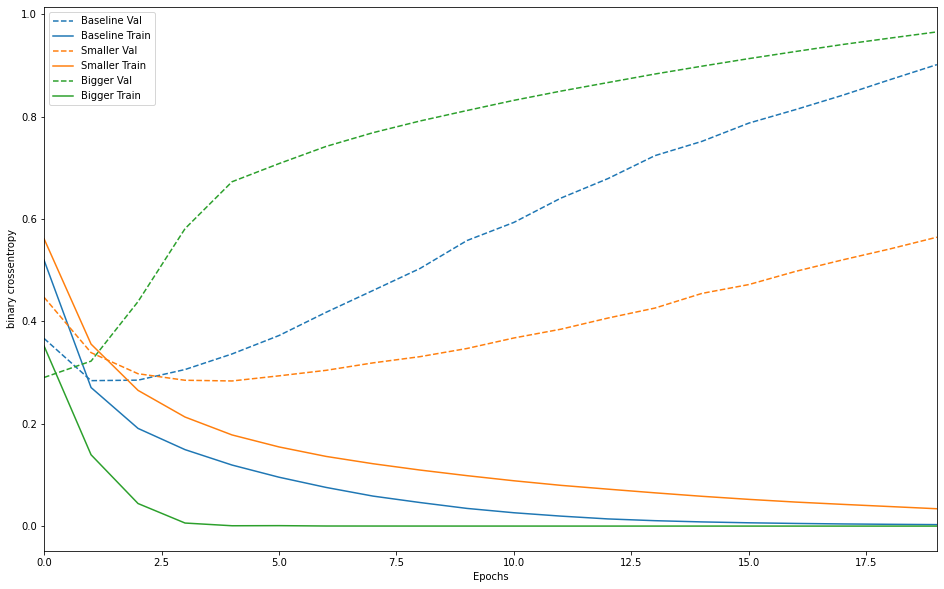

In [19]:
def plot_history(histories, key = 'binary_crossentropy'):
    plt.figure(figsize=(16,10))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],'--',label = name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color = val[0].get_color(), label = name.title()+' Train')
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' '.title()))
    plt.legend()
    plt.xlim([0, max(history.epoch)])

plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

* **より大きいネットワークはほとんど直ちに、overfittingし始める**

## 対策:重み正規化を加える
* 単純なモデル
    * overfittingを軽減する一般的な方法はその重みを小さい値だけを取るように強制してネットワークの複雑さに制約を置く
* 「正則(=regular)」にします。
    * 重み正規化
    * ネットワークの損失関数に巨大な重みをもつことに関連するコストを追加することによる
* **L1正則化**：ここでは追加されるコストは重み係数への「L1ノルム」絶対値への比例項です
* **L2正則化**：重み係数の値の二乗への「L2ノルム」の比例項です
    * ニューラルネットワークのコンテキストでは重み減衰とも呼称されます
    * 異なる名前に混乱してはいけません、
    * L2正則化と正確時同じです

In [20]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
 
l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])
 
l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Epoch 1/20
49/49 - 5s - loss: 0.5513 - accuracy: 0.7862 - binary_crossentropy: 0.5104 - val_loss: 0.3880 - val_accuracy: 0.8764 - val_binary_crossentropy: 0.3458
Epoch 2/20
49/49 - 2s - loss: 0.3066 - accuracy: 0.9086 - binary_crossentropy: 0.2600 - val_loss: 0.3331 - val_accuracy: 0.8893 - val_binary_crossentropy: 0.2832
Epoch 3/20
49/49 - 2s - loss: 0.2503 - accuracy: 0.9299 - binary_crossentropy: 0.1980 - val_loss: 0.3388 - val_accuracy: 0.8847 - val_binary_crossentropy: 0.2849
Epoch 4/20
49/49 - 2s - loss: 0.2259 - accuracy: 0.9420 - binary_crossentropy: 0.1702 - val_loss: 0.3611 - val_accuracy: 0.8788 - val_binary_crossentropy: 0.3042
Epoch 5/20
49/49 - 2s - loss: 0.2107 - accuracy: 0.9478 - binary_crossentropy: 0.1525 - val_loss: 0.3675 - val_accuracy: 0.8761 - val_binary_crossentropy: 0.3085
Epoch 6/20
49/49 - 2s - loss: 0.1993 - accuracy: 0.9534 - binary_crossentropy: 0.1395 - val_loss: 0.3839 - val_accuracy: 0.8747 - val_binary_crossentropy: 0.3235
Epoch 7/20
49/49 - 2s - loss

* kernel_regularizer=keras.regularizers.l2(0.001)
    * は、層の重み行列の総ての係数が0.001 * weight_coefficient_valueをネットワークの総計損失に追加

## プロットしましょう

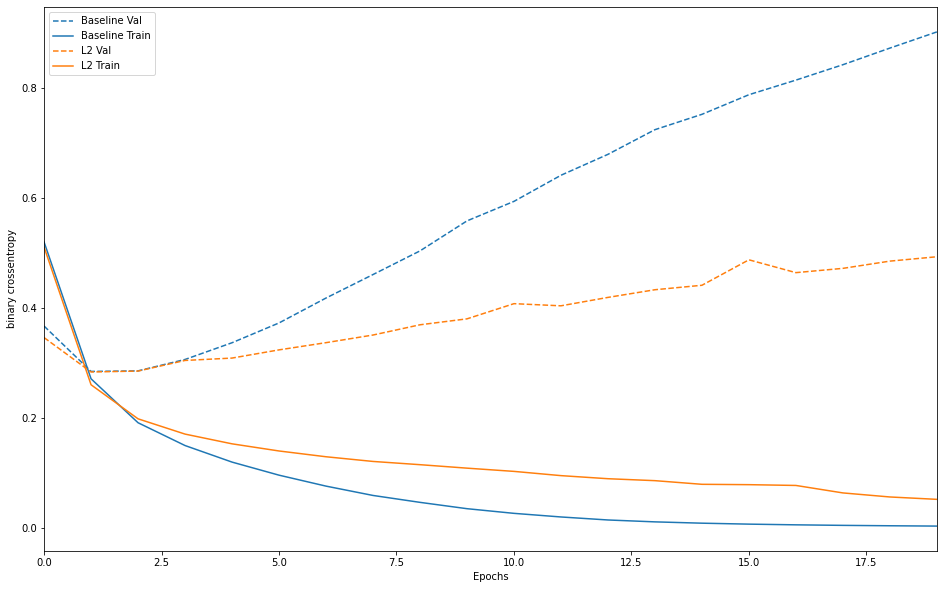

In [21]:
def plot_history(histories, key = 'binary_crossentropy'):
    plt.figure(figsize=(16,10))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],'--',label = name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color = val[0].get_color(), label = name.title()+' Train')
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' '.title()))
    plt.legend()
    plt.xlim([0, max(history.epoch)])

plot_history([('Baseline', baseline_history),
              ('L2', l2_model_history)])

## Dropoutを追加する
* 正則化のテクニックの一つで、trainingの間層の出力特徴の数をランダムに、
    * "dropping out"（ゼロに設定）することから成ります。
    * 訓練の間に与えられた入力サンプルに対して与えられた走破通常はベクトル[0.2, 0.5, 1.3, 0.8, 1.1]を返したと仮定します
    * このベクトルはランダムに分布するいくつかのゼロ要素を持つ
    * [0, 0.5, 1.3, 0, 1.1]です。
    * dropout rate is ゼロの割合です
    

In [4]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
 
dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])
 
dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 2s - loss: 0.6218 - accuracy: 0.6514 - binary_crossentropy: 0.6218 - val_loss: 0.4768 - val_accuracy: 0.8552 - val_binary_crossentropy: 0.4768
Epoch 2/20
49/49 - 2s - loss: 0.4547 - accuracy: 0.8095 - binary_crossentropy: 0.4547 - val_loss: 0.3389 - val_accuracy: 0.8826 - val_binary_crossentropy: 0.3389
Epoch 3/20
49/49 - 2s - loss: 0.3496 - accuracy: 0.8667 - binary_crossentropy: 0.3496 - val_loss: 0.2913 - val_accuracy: 0.8892 - val_binary_crossentropy: 0.2913
Epoch 4/20
49/49 - 2s - loss: 0.2915 - accuracy: 0.8948 - binary_crossentropy: 0.2915 - val_loss: 0.2767 - val_accuracy: 0.8877 - val_binary_crossentropy: 0.2767
Epoch 5/20
49/49 - 2s - loss: 0.2454 - accuracy: 0.9146 - binary_crossentropy: 0.2454 - val_loss: 0.2769 - val_accuracy: 0.8884 - val_binary_crossentropy: 0.2769
Epoch 6/20
49/49 - 2s - loss: 0.2137 - accuracy: 0.9283 - binary_crossentropy: 0.2137 - val_loss: 0.2922 - val_accuracy: 0.8869 - val_binary_crossentropy: 0.2922
Epoch 7/20
49/49 - 2s - loss

In [5]:
def plot_history(histories, key = 'binary_crossentropy'):
    plt.figure(figsize=(16,10))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],'--',label = name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color = val[0].get_color(), label = name.title()+' Train')
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' '.title()))
    plt.legend()
    plt.xlim([0, max(history.epoch)])

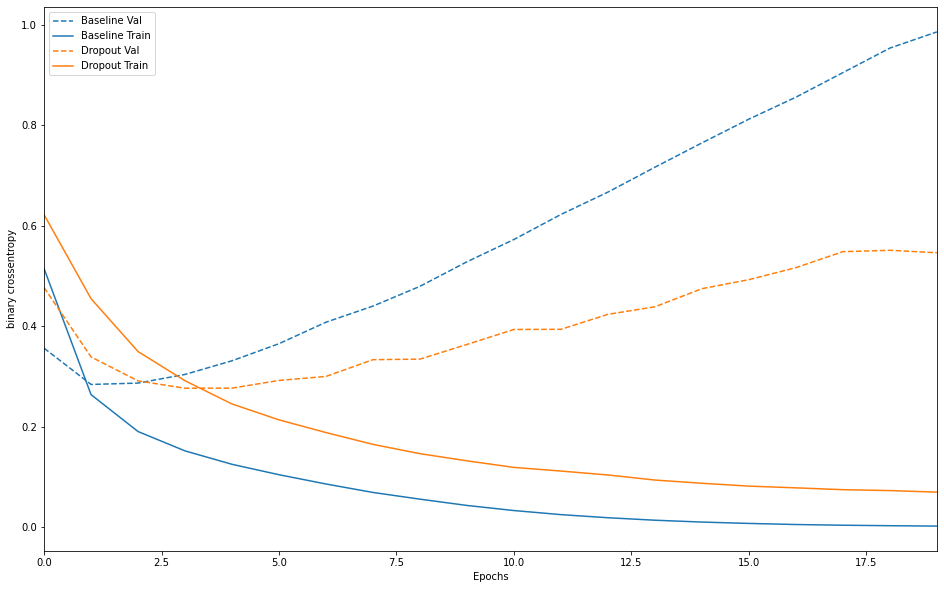

In [9]:
	
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])